In [49]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [55]:
# Import necessary libraries
#from src.models import RENR
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
from os.path import dirname, join as pjoin
import torch
from torch import nn
import scipy.signal as signal

# Set data type and device
dtype = torch.float
device = "cuda" if torch.cuda.is_available() else "cpu"
#device = torch.device("cpu")
print(device)
# Close all open plots
plt.close('all')

cuda


In [56]:
# Load data from file
folderpath = os.getcwd()
filepath = pjoin(folderpath, 'input.mat')
data_in = scipy.io.loadmat(filepath)
filepath = pjoin(folderpath, 'output.mat')
data_out = scipy.io.loadmat(filepath)

# Extract data from dictionary
dExp, yExp, dExp_val, yExp_val, time__ = data_in['dExp'], data_out['yExp'], \
    data_in['dExp_val'], data_out['yExp_val'], data_in['time__']
    
nExp = yExp.size



In [57]:
# Create time vector
t = time__

# Set end time
t_end = t.size

# Set input number
input_size = 5
inputnumberD = input_size-1

# Set random seed for reproducibility
seed = 1
torch.manual_seed(seed)

In [61]:
#Set dimensions for RNN layers
n = dExp[0, 0].shape[1] # input dimensions--nb of col
p = yExp[0, 0].shape[1] # output dimensions
n_xi = 20 #linear matrix dimension
l = 20 # in the paper q, dimension of the square matrix D11 -- number of non-linear layers of the RE

REN = RENR(n, p, n_xi, l)
REN = REN.to(device)

#REN.load_state_dict(torch.load('parameters_REN.pth'))

# Define Loss function
MSE = nn.MSELoss()

# Define Optimization method
learning_rate = 5.0e-3
optimizer = torch.optim.Adam(REN.parameters(), lr=learning_rate)
optimizer.zero_grad()

# Set number of epochs
epochs = 10
LOSS = np.zeros(epochs)


AttributeError: 'Tensor' object has no attribute 'linear'

In [ ]:
#graduating learning rate
t_end = int(t_end/6)
#t_end = int(np.ceil(t_end)) - 1
 #to have less data and it takes less time ...
for epoch in range(epochs):
    print('epoch new')
    if epoch == epochs - epochs / 2:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(REN.parameters(), lr=learning_rate)
    if epoch == epochs - epochs / 6:
        learning_rate = 1.0e-4
        optimizer = torch.optim.Adam(REN.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    loss = 0
    
    #loop over the experiments
    #torch.autograd.set_detect_anomaly(True) # to detect error 
    for exp in range(nExp):
        print('in loop')
        #get output
        y = torch.from_numpy(yExp[0, exp]).float().to(device)
        y = y.squeeze() #??
        yRENm = torch.randn([p, t_end], device=device, dtype=dtype) #same if torch.zeros ?
        y = y.T
        yRENm[:,0] = y[:t_end,0]
        xi = torch.randn(n_xi).to(device)
        #get input
        d = torch.from_numpy(dExp[0, exp]).float().to(device).T #????????
        for t in range(1, t_end):
            u = torch.tensor(d[:, t]).to(device)  #[inputnumberD, t]])
            yRENm[:, t], xi = REN(t, u, xi)      
            print(t)# prend la nonlin du precedent step pour calculer le REN suivant
        loss = loss + MSE(yRENm[:, 0:yRENm.size(1)], y[:, 0:t_end ])
        #torch.save(REN.state_dict(), filename)
        
    # Calculate loss mean and backpropagate
    print('lossnorm')
    loss = loss / nExp
    loss.backward()
    print('lossbackward')
    #loss.backward(retain_graph=True)
    print('optimizer')
    optimizer.step()
    print('set_model_param')
    REN.set_model_param()

    print(f"Epoch: {epoch + 1} \t||\t Loss: {loss}")
    print(f"Gamma1: {REN.sg ** 2}")
    LOSS[epoch] = loss


epoch new
in loop


C:\Users\adela\AppData\Local\Temp\ipykernel_4196\1302404796.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u = torch.tensor(d[:, t]).to(device)  #[inputnumberD, t]])


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument tensor in method wrapper_CUDA__dot)

In [ ]:
# takes too much time .... don't run...
t_end = int(np.ceil(t_end / 3)) - 1  # Ensure t_end is an integer
for epoch in range(epochs):
    # Adjust learning rate at specific epochs
    if epoch == epochs - epochs // 2:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(REN.parameters(), lr=learning_rate)
    elif epoch == epochs - epochs // 6:
        learning_rate = 1.0e-4
        optimizer = torch.optim.Adam(REN.parameters(), lr=learning_rate)
    
    optimizer.zero_grad()
    total_loss = 0  # Initialize the loss for the epoch

    # Loop over the experiments
    for exp in range(nExp - 1):
        # Prepare output data
        y = torch.from_numpy(yExp[0, exp]).float().to(device).squeeze().T
        yRENm = torch.zeros((p, t_end + 1), device=device, dtype=dtype)  # Initialize with zeros
        
        yRENm[:, 0] = y[:, 0]  # Set initial condition
        
        # Initialize state variables
        xi = torch.randn(n_xi).to(device)
        
        # Prepare input data
        d = torch.from_numpy(dExp[0, exp]).float().to(device).T
        
        # Time iteration for the current experiment
        for t in range(1, t_end):
            u = d[:, t]  # Get input at time step t
            
            # Forward pass in REN
            yRENm[:, t], xi = REN(t, u, xi.detach())  # Detach xi to avoid in-place modification issues

        # Compute MSE loss for the experiment
        exp_loss = MSE(yRENm[:, :t_end + 1], y[:, :t_end + 1])
        total_loss += exp_loss  # Accumulate loss over experiments

    # Calculate mean loss over experiments
    mean_loss = total_loss / nExp
    mean_loss.backward()  # Backward pass to compute gradients

    optimizer.step()  # Update model parameters
    REN.set_model_param()  # Update any internal parameters after optimization step

    # Logging for each epoch
    print(f"Epoch: {epoch + 1} \t||\t Loss: {mean_loss.item()}")
    print(f"Gamma1: {REN.sg ** 2}")
    LOSS[epoch] = mean_loss.item()


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument tensor in method wrapper_CUDA__dot)

In [ ]:
##############################################



yval = torch.from_numpy(yExp_val[0, 0]).float().to(device)
yval = yval.T
yval = yval.squeeze()

yRENm_val = torch.zeros(p, t_end, device=device, dtype=dtype)
yRENm_val[:,0] = yval[:,0]
xiVal = torch.randn(n_xi)
dval = torch.from_numpy(dExp_val[0, 0]).float().to(device).T
loss_val = 0
for t in range(1, t_end):
    u = torch.tensor(dval[:, t])#[inputnumberD, t])
    yRENm_val[:, t], xiVal = REN(t, u, xiVal)
loss_val = loss_val + MSE(yRENm_val[:, 0:yRENm_val.size(1)], yval[:, 0:t_end])
 ##############################################


C:\Users\adela\AppData\Local\Temp\ipykernel_23104\960408005.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u = torch.tensor(dval[:, t])#[inputnumberD, t])


In [ ]:
###############""# Initialize input and output tensors for validation data
nExp = yExp_val.size
uval = torch.zeros(nExp, t_end, input_size)
yval = torch.zeros(nExp, t_end, 2)

# Fill input and output tensors with validation data
for j in range(nExp):
    inputActive = (torch.from_numpy(dExp_val[0, j]))#[:,:-1]))
    uval[j, :, :] = torch.unsqueeze(inputActive[:,inputnumberD], 1)
    yval[j, :, :] = (torch.from_numpy(yExp_val[0, j]))
    #uval[j, :, 4] = torch.from_numpy(signal.medfilt((uval[j, :, 4]).numpy(), 25))

# Get RNN output for validation data
yREN_val = REN(uval)
yREN_val = yREN_val.unsqueeze_(0)

# Calculate loss for validation data
loss_val = MSE(yREN_val, yval)

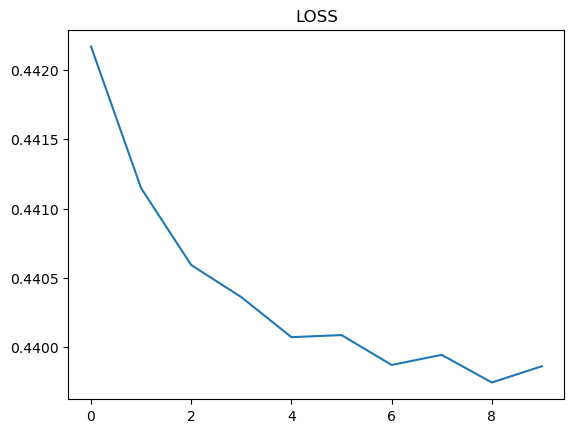

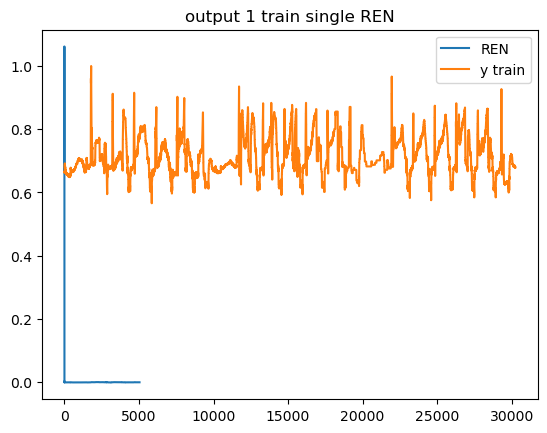

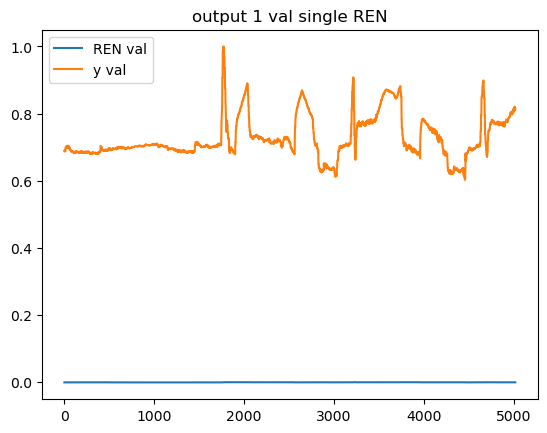

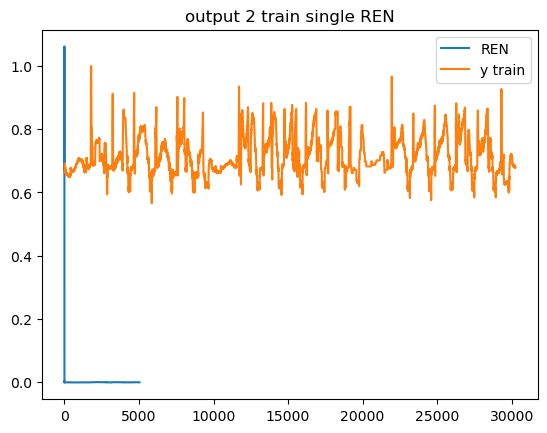

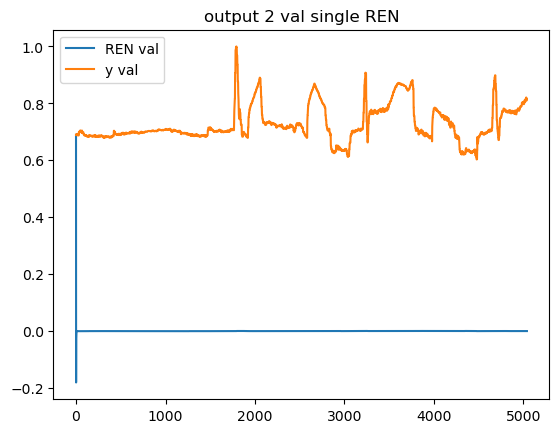

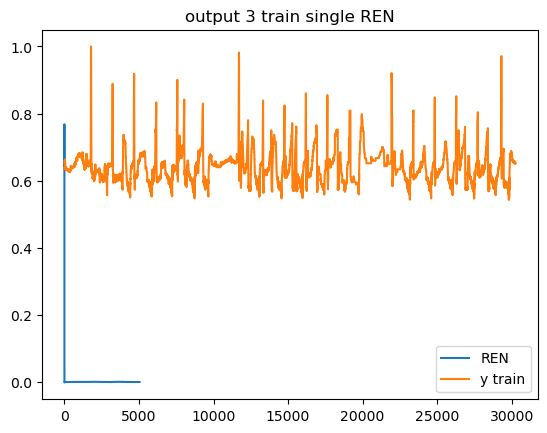

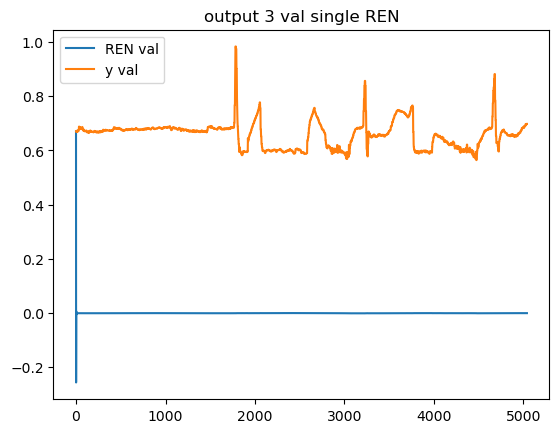

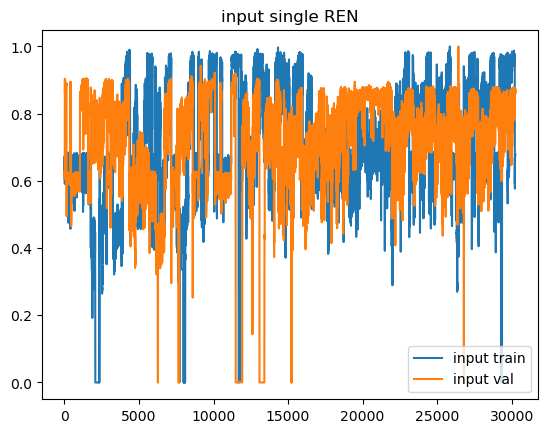

param single REN: 4331
Loss Validation single REN: 0.4854724109172821


In [ ]:
plt.figure('8')
plt.plot(LOSS)
plt.title("LOSS")
plt.show()

plt.figure('9')
plt.plot(yRENm[0, :].detach().numpy(), label='REN')
plt.plot(y[0, :].detach().numpy(), label='y train')
plt.title("output 1 train single REN")
plt.legend()
plt.show()

plt.figure('10')
plt.plot(yRENm_val[0, 20:t_end].detach().numpy(), label='REN val')
plt.plot(yval[0, 20:t_end].detach().numpy(), label='y val')
plt.title("output 1 val single REN")
plt.legend()
plt.show()

plt.figure('11')
plt.plot(yRENm[0, :].detach().numpy(), label='REN')
plt.plot(y[0, :].detach().numpy(), label='y train')
plt.title("output 2 train single REN")
plt.legend()
plt.show()

plt.figure('12')
plt.plot(yRENm_val[0, 0:t_end].detach().numpy(), label='REN val')
plt.plot(yval[0, 0:t_end].detach().numpy(), label='y val')
plt.title("output 2 val single REN")
plt.legend()
plt.show()

plt.figure('13')
plt.plot(yRENm[1, :].detach().numpy(), label='REN')
plt.plot(y[1, :].detach().numpy(), label='y train')
plt.title("output 3 train single REN")
plt.legend()
plt.show()

plt.figure('14')
plt.plot(yRENm_val[1, 0:t_end].detach().numpy(), label='REN val')
plt.plot(yval[1, 0:t_end].detach().numpy(), label='y val')
plt.title("output 3 val single REN")
plt.legend()
plt.show()


plt.figure('15')
plt.plot(d[inputnumberD, :].detach().numpy(), label='input train')
plt.plot(dval[inputnumberD, :].detach().numpy(), label='input val')
plt.title("input single REN")
plt.legend()
plt.show()

pytorch_total_params_single = sum(p.numel() for p in REN.parameters() if p.requires_grad)

print(f"param single REN: {pytorch_total_params_single}")

print(f"Loss Validation single REN: {loss_val}")